# 🦴 Vertebral Finite Element Model Generation Notebook

This notebook demonstrates how to generate finite element analysis (FEA) models of vertebral segments from density-calibrated CT images using the `OGO` spine compression pipeline. We go through:

1. Loading the calibrated image and segmented labels.
2. Extracting bone sub-regions and converting to material ID maps.
3. Visualizing masks and model inputs.
4. Creating two types of FE models:
   - **Linear** (elastic-only)
   - **Nonlinear** (elastic + plastic with yield)

---

> 🔧 Prerequisites:
> - Calibrated image (`*_im.nii.gz`)
> - Segmentation mask (`*_seg.nii.gz`)

---


In [1]:
# Load Libraries and Read Inputs
from ogo.cli.ref.SpineCompressionFe import create_microfe_model, read, convert_image_to_material, threshold, merge_vtk_images
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
import vtk
import numpy as np
import matplotlib.pyplot as plt
import vtkbone

# Define paths
input_image = "../data/nii_files/sub-verse004_0000_vertebra_21_im.nii.gz"
input_mask = "../data/nii_files/sub-verse004_0000_vertebra_21_seg.nii.gz"
output_model_linear = "../data/nii_files/sub-verse004_0000_vertebra_21_linear.n88model"
output_model_nonlinear = "../data/nii_files/sub-verse004_0000_vertebra_21_nonlinear.n88model"

# Read image and mask
input_image = read(input_image).GetOutput()
input_mask_with_disk = read(input_mask).GetOutput()


## 🧩 Preprocessing Helper Functions

We'll define utility functions to extract specific sub-regions from the label image and to visualize the resulting masks.


In [2]:
def label_mask_from_vtk(vtk_image, condition_fn):
    arr = vtk_to_numpy(vtk_image.GetPointData().GetScalars()).reshape(vtk_image.GetDimensions(), order='F')
    out_arr = condition_fn(arr).astype(np.uint8)
    out_vtk = vtk_image.NewInstance()
    out_vtk.DeepCopy(vtk_image)
    out_vtk.GetPointData().SetScalars(numpy_to_vtk(out_arr.ravel(order='F'), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR))
    return out_vtk

def plot_vtk(mask_list, axis='x', index=None, cmap='tab20b'):
    fig, axes = plt.subplots(1, len(mask_list), figsize=(4 * len(mask_list), 4))
    axes = axes if isinstance(axes, (list, np.ndarray)) else [axes]
    axis_idx = {'x': 0, 'y': 1, 'z': 2}[axis]

    for ax, (mask, title) in zip(axes, mask_list):
        dims = mask.GetDimensions()
        arr = vtk_to_numpy(mask.GetPointData().GetScalars()).reshape(dims, order='F')
        idx = index if index is not None else dims[axis_idx] // 2
        slice_2d = arr[idx, :, :] if axis == 'x' else arr[:, idx, :] if axis == 'y' else arr[:, :, idx]
        ax.imshow(slice_2d.T, cmap=cmap, origin='lower')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


## 🧠 Segment Bone Subregions

Here we split the segmentation mask into:
- **Cortical mask**: labels 2, 4
- **Disk mask**: PMMA top/bottom disks (labels 5, 6)
- **Vertebra mask**: remapped as 1 = trabecular body/process, 2 = cortical body/process


In [3]:
cortical_mask = label_mask_from_vtk(input_mask_with_disk, lambda x: np.isin(x, [2, 4]))
disk_mask = label_mask_from_vtk(input_mask_with_disk, lambda x: np.isin(x, [5, 6]))
vertebra_mask = label_mask_from_vtk(input_mask_with_disk, lambda x: np.where(np.isin(x, [1, 2]), 1, np.where(np.isin(x, [3, 4]), 2, 0)))


## 🔄 Convert Image to Material ID Map

This step:
- Applies image preprocessing and binning
- Converts density to material IDs (1–128 for trabecular, 129–256 for cortical)
- Merges disk labels (ID = 300)


In [4]:
n_bins = 128
binned_image, bin_centers = convert_image_to_material(input_image, vertebra_mask, n_bins=n_bins, cort_mask=cortical_mask)
input_image_with_disk = merge_vtk_images([binned_image, disk_mask], [None, 300])


## 🖼️ Visualize Masks and Material ID Image



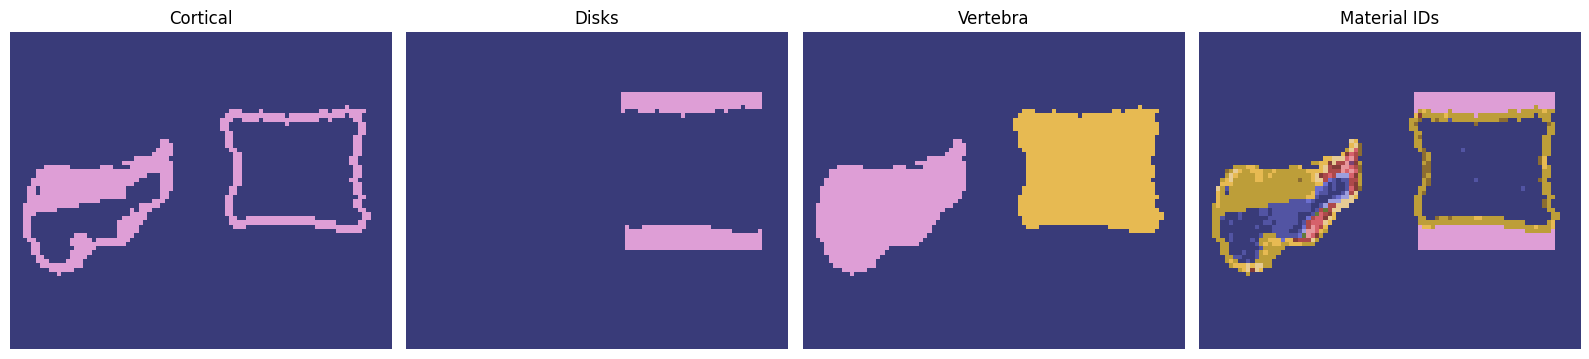

In [5]:
plot_vtk([
    (cortical_mask, 'Cortical'),
    (disk_mask, 'Disks'),
    (vertebra_mask, 'Vertebra'),
    (input_image_with_disk, 'Material IDs')
])


## 🧪 Build Linear Model

A simple elastic model using Kopperdahl's density–modulus relation. No yield behavior is included.


In [6]:
model_params_linear = {
    "poissons_ratio": 0.3,
    "pmma_mat_id": 300,
    "pmma_E": 2500,
    "pmma_v": 0.3,
    "top_node_set_id": 6,
    "bottom_node_set_id": 5,
    "top_direction": (0, 0, 1),
    "bottom_direction": (0, 0, -1),
    "fe_displacement": -0.2,
    "pmma_yield_compression": None,
    "pmma_yield_tension": None,
    "cort_poissons_ratio": None,
    "elastic_E_func": "kopperdahl_trab_E",
    "yield_comp_func": None,
    "yield_tens_func": None,
    "cort_elastic_E_func": "kopperdahl_trab_E",
    "cort_yield_comp_func": None,
    "cort_yield_tens_func": None,
}

model_linear = create_microfe_model(input_image_with_disk, input_mask_with_disk, bin_centers, **model_params_linear)

writer = vtkbone.vtkboneN88ModelWriter()
writer.SetInputData(model_linear)
writer.SetFileName(output_model_linear)
writer.Update()


    0.63 ========= FE MODEL ARGUMENTS =========
    0.63 n_bins: 128
    0.63 poissons_ratio: 0.3
    0.63 pmma_mat_id: 300
    0.63 pmma_E: 2500
    0.63 pmma_v: 0.3
    0.63 top_displacement: top_displacement
    0.63 top_direction: (0, 0, 1)
    0.63 bottom_direction: (0, 0, -1)
    0.63 top_node_set_id: 6
    0.63 bottom_node_set_id: 5
    0.63 top_node_set_name: body_top
    0.63 bottom_node_set_name: body_bottom
    0.63 pmma_yield_compression: None
    0.63 pmma_yield_tension: None
    0.63 elastic_E_func: function -> kopperdahl_trab_E
    0.63 yield_comp_func: None
    0.63 yield_tens_func: None
    0.63 cort_elastic_E_func: function -> kopperdahl_trab_E
    0.63 cort_yield_comp_func: None
    0.63 cort_yield_tens_func: None
    0.63 cort_poissons_ratio: 0.3
    0.63 ======================================
    0.63 Casting to Short Integer datatype...
    0.63 Filtering connected components...
    0.65 Meshing...
    0.69 Generated 67137 hexahedrons
    0.69 Generated 77892 node

## 🔩 Build Nonlinear Model

Same model, but with nonlinear plastic behavior for both trabecular and cortical regions.


In [7]:
# Define the kwargs in a dictionary
model_params_nonlinear = {
    "poissons_ratio": 0.3,
    "pmma_mat_id": 300,
    "pmma_E": 2500,
    "pmma_v": 0.3,
    "top_node_set_id": 6,
    "bottom_node_set_id": 5,
    "top_direction": (0, 0, 1),
    "bottom_direction": (0, 0, -1),
    "fe_displacement": -2.0, #2% displacement for nonlinear
    "pmma_yield_compression": 70.0,
    "pmma_yield_tension": 70.0,
    "cort_poissons_ratio": None,
    "elastic_E_func": "kopperdahl_trab_E",
    "yield_comp_func": "kopperdahl_trab_yc",
    "yield_tens_func": "kopperdahl_trab_yc",
    "cort_elastic_E_func": "kopperdahl_trab_E",
    "cort_yield_comp_func": "kopperdahl_trab_yc",
    "cort_yield_tens_func": "kopperdahl_trab_yc",
}

# Creating the micro-FE model according to the model parameters
model_nonlinear = create_microfe_model(input_image_with_disk,input_mask_with_disk,bin_centers, **model_params_nonlinear)

writer = vtkbone.vtkboneN88ModelWriter()
writer.SetInputData(model_nonlinear)
writer.SetFileName(output_model_nonlinear)
writer.Update()

    3.08 ========= FE MODEL ARGUMENTS =========
    3.08 n_bins: 128
    3.08 poissons_ratio: 0.3
    3.08 pmma_mat_id: 300
    3.08 pmma_E: 2500
    3.08 pmma_v: 0.3
    3.08 top_displacement: top_displacement
    3.08 top_direction: (0, 0, 1)
    3.08 bottom_direction: (0, 0, -1)
    3.08 top_node_set_id: 6
    3.08 bottom_node_set_id: 5
    3.08 top_node_set_name: body_top
    3.08 bottom_node_set_name: body_bottom
    3.08 pmma_yield_compression: 70.0
    3.08 pmma_yield_tension: 70.0
    3.08 elastic_E_func: function -> kopperdahl_trab_E
    3.08 yield_comp_func: function -> kopperdahl_trab_yc
    3.08 yield_tens_func: function -> kopperdahl_trab_yc
    3.08 cort_elastic_E_func: function -> kopperdahl_trab_E
    3.08 cort_yield_comp_func: function -> kopperdahl_trab_yc
    3.08 cort_yield_tens_func: function -> kopperdahl_trab_yc
    3.08 cort_poissons_ratio: 0.3
    3.08 ======================================
    3.08 Casting to Short Integer datatype...
    3.08 Filtering connec

### Running the Finite Element Model with FAIM

To solve the generated `.n88model` files using FAIM (Finite element Analysis for Internal Mechanisms), follow the basic commands below. These commands run the finite element analysis and generate output files containing mechanical response and post-processing information.

#### ⚙️ For Linear Simulations
Use fewer threads (e.g., 6) and no additional parameters:

```bash
faim --engine=mt --threads=6 path/to/model_linear.n88model
```

#### 🧠 For Nonlinear Simulations
Set more threads and specify additional parameters for plasticity:

```bash
faim --engine=mt --threads=12 --maximum_plastic_iterations=10000 path/to/model_nonlinear.n88model
```

---

### 📦 FAIM Software and Licensing
FAIM is **openly available**, but requires a license which must be requested. The licensing process and installation instructions are described here:

📄 **FAIM Installation & Licensing Manual**:  
https://bonelab.github.io/n88/documentation/faim/9.0/doc/manual/html/index.html#installation

🔗 **FAIM Main Page**:  
https://bonelab.github.io/n88/

---

### 🖥️ Visualizing the `.n88model` in ParaView
You can inspect and visualize `.n88model` files using **ParaView** with the provided `n88model` plugin.

🔍 Download the plugins and tools here:  
https://bonelab.github.io/n88/downloads/index.html

Once installed, ParaView can be used to visualize elements, node sets, and simulation results directly from the `.n88model` or the result files.

---

For more detailed documentation, post-processing options, and examples, refer to the full manual:

📚 https://bonelab.github.io/n88/documentation/faim/9.0/doc/manual/html/index.html